In [1]:
import nltk
from nltk import corpus
from nltk.collocations import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import wordnet
from nltk import punkt
from nltk.util import ngrams
from nltk import FreqDist

import re
from bs4 import BeautifulSoup
import unicodedata
from six import iteritems
from string import punctuation
from collections import Counter
import numpy as np
import calendar

In [2]:
import gensim
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities.docsim import MatrixSimilarity

import pandas as pd
from datetime import datetime

#Importing sklearn for bigram finder
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline


## Import and Clean Connect Report

In [4]:
report=pd.read_csv('updated_connect_report.csv')

#trandforming the Date column in to pandas dates
report['Created Date']=pd.to_datetime(report['Created Date'])

#removing null records
report=report[pd.notnull(report['Created Date'])]
report=report[pd.notnull(report['Body'])]

#Removing HTML tags and codes
report['Body'] = report['Body'].apply(lambda x:BeautifulSoup(x))
report['Body'] = report['Body'].apply(lambda x:x.get_text())

#Removing tags/mentions
report['Body'] = report['Body'].apply(lambda x:re.sub('{@[\w\d]*}', '',x))

#Removing urls
report['Body'] = report['Body'].apply(lambda x:re.sub(r'^https?:\/\/.*[\r\n]*', '', x,flags=re.MULTILINE))

#Removing weird unicode characters
report['Body'] = report['Body'].apply(lambda x: x.encode('ascii', 'ignore'))

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\bs4\__init__.py:181: UserWarning:

No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")




## Report Generator

In [79]:
final_report=pd.DataFrame

#Use this function to create the final report for analysis
# Directions:
# 1. Set Group to a list of group names, a single name of a group, or All to use all groups
# 2. Set Type to a specific Feed Item Type or All
# 3. Set Start Date or leave blank(defaults to: 1/1/2017)
# 4. Set End Date or leave blank(defaults to: Today's date)

def report_generator(Group,Type,Date_start=pd.to_datetime("2017-01-01"),Date_finish=pd.to_datetime('today')):
    if type(Group) == list:
        final_report=report.loc[report['Name'].isin(Group)] 
    elif (Group=='All'):
        final_report=report
    else:
        final_report=report.loc[report['Name']==Group]
                                
    if (Type=='All'):
        final_report=final_report
    else:
        final_report=final_report.loc[final_report['Feed Item Type']==Type]
    
    if(Date_start=="2017-01-01" and Date_finish== pd.to_datetime('today')):
        final_report=final_report
    else:
        Date_start=pd.to_datetime(Date_start, utc=False)
        Date_finish=pd.to_datetime(Date_finish, utc=False)
        final_report=final_report[(final_report['Created Date'] > Date_start) & (final_report['Created Date']< Date_finish)]   
    return(final_report)


final_report=report_generator(['CPC+ All','NLT Internal Users'],'All',"2017-01-01","2018-04-06")

#sample final report
final_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type
6,CPC Plus Connect,CPC+ All,Walker Sands,Booz Allen Hamilton,"CPC+ PRACTICE PORTAL OUTAGE ALERT: Today, Thur...",2018-04-05,2.0,0.0,Text Post
7,CPC Plus Connect,CPC+ All,Angela Oiler,OH,Our practice has not yet received an email reg...,2018-04-05,1.0,3.0,Text Post
8,CPC Plus Connect,CPC+ All,Brian Litz,CapitalCare Family Practice Ravena,Hi All! Would someone kindly clarify how the p...,2018-04-05,1.0,2.0,Text Post
9,CPC Plus Connect,CPC+ All,Paula Manning,Premier Health Associates,When running our continuity of care reporting ...,2018-04-05,1.0,10.0,Text Post
10,CPC Plus Connect,CPC+ All,Jennifer Rodrigues,Robert Wood Johnson Medical Group/Family Medicine,I need some help in clarifying the ECQM Pneumo...,2018-04-05,0.0,2.0,Text Post


## Tokenizer Function

In [80]:
##Stop word and lemmatizer creation (PLEASE add to stop where you see fit)
stop = stopwords.words('english')
stop.append("cpc+")
stop.append("hi")
stop.append("hello")
stop.append("also")
stop.append("anyone")
stop.append("et")
stop.append("please")
stop.append("would")
stop.append("should")
stop.append("would")
stop.append("march")
stop.append("february")
stop.append("everyone")
stop.append("join")
stop.append("need")
stop.append("check")
stop.append("click")
stop.append("u")
stop.append("thursday")
stop.append("ellen")
stop.append("april")
stop.append("friday")
stop.append("currently")
stop.append("regarding")
stop.append("thank")
stop.append("session")
stop.append("pm")

wnl = WordNetLemmatizer() 

In [81]:
#this function tokenizes text (single and bigrams), removes stop word and punctuation, and lemmatizes the tokens
def tokenizer(text, extend_bigrams = True):
 
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text.lower())]
    
    tokens = []
    
    for token_by_sent in tokens_:
        tokens += token_by_sent
 
    tokens = list(filter(lambda t: t not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"u",u"'s", u"n't",u"'ve",u"'re",u"'d",u"'ll",u"'m", u" u", 
                                             u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
     
    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
 
    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
   
    if extend_bigrams == True:
        
        bigrm = nltk.bigrams(filtered_tokens)
        bi_tokens = []
        for a, b in bigrm:
            bi_tok = ' '.join((a, b))
            bi_tokens.append(bi_tok)

        filtered_tokens.extend(bi_tokens)
    
    return filtered_tokens

In [82]:
#tokenizes final report
final_report['tokens'] = final_report['Body'].map(tokenizer)

#sample tokens
final_report.head()

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type,tokens
6,CPC Plus Connect,CPC+ All,Walker Sands,Booz Allen Hamilton,"CPC+ PRACTICE PORTAL OUTAGE ALERT: Today, Thur...",2018-04-05,2.0,0.0,Text Post,"[practice, portal, outage, alert, today, 5th, ..."
7,CPC Plus Connect,CPC+ All,Angela Oiler,OH,Our practice has not yet received an email reg...,2018-04-05,1.0,3.0,Text Post,"[practice, yet, received, email, care, deliver..."
8,CPC Plus Connect,CPC+ All,Brian Litz,CapitalCare Family Practice Ravena,Hi All! Would someone kindly clarify how the p...,2018-04-05,1.0,2.0,Text Post,"[someone, kindly, clarify, performance, rate, ..."
9,CPC Plus Connect,CPC+ All,Paula Manning,Premier Health Associates,When running our continuity of care reporting ...,2018-04-05,1.0,10.0,Text Post,"[running, continuity, care, reporting, reporti..."
10,CPC Plus Connect,CPC+ All,Jennifer Rodrigues,Robert Wood Johnson Medical Group/Family Medicine,I need some help in clarifying the ECQM Pneumo...,2018-04-05,0.0,2.0,Text Post,"[help, clarifying, ecqm, pneumococcal, vaccina..."


In [83]:
##Bi-Grams using Sci-Kit Learn
##Finding bigrams and frequencies across all data

single_tokens = final_report['Body'].apply(lambda x: tokenizer(x, extend_bigrams = False))
unlisted_report=single_tokens.apply(lambda x: ','.join(x))

word_vectorizer=CountVectorizer(ngram_range=(1,2), analyzer='word')
word_vectorizer_fit=word_vectorizer.fit_transform(unlisted_report)

frequencies=sum(word_vectorizer_fit).toarray()[0]

total_post_counter=pd.DataFrame(frequencies,index=word_vectorizer.get_feature_names(),columns=['frequency'])

filtered_post_counter = total_post_counter[total_post_counter['frequency']>10].copy()

filtered_post_counter.sort_values(by=['frequency'],ascending=False, inplace=True)
filtered_post_counter.head(15)


,frequency
practice,1050
patient,790
care,741
group,419
reporting,379
report,349
question,304
information,276
health,272
risk,241


In [84]:
#Take a list of the top 10 most frequent words and then track their usage throughout the report period.

def single_day_tracker(report):
    
    #Create the top 10 list
    single_tokens = final_report['Body'].apply(lambda x: tokenizer(x, extend_bigrams = False))
    unlisted_report=single_tokens.apply(lambda x: ','.join(x))

    word_vectorizer=CountVectorizer(ngram_range=(1,2), analyzer='word')
    word_vectorizer_fit=word_vectorizer.fit_transform(unlisted_report)

    frequencies=sum(word_vectorizer_fit).toarray()[0]

    total_post_counter=pd.DataFrame(frequencies,index=word_vectorizer.get_feature_names(),columns=['frequency'])

    filtered_post_counter = total_post_counter[total_post_counter['frequency']>10].copy()

    filtered_post_counter.sort_values(by=['frequency'],ascending=False, inplace=True)
    top_words = filtered_post_counter.head(5).copy()
    
    top_words_listed=list(top_words.index)


    #Okay now figure out what the frequency was each day
    unique_dates=set(report['Created Date'])
    list_dates=sorted(list(unique_dates))
    list_df_name=list(xrange(0,len(list_dates)))
    list_df=[]
    new_df=pd.DataFrame
    for i in xrange(0,len(list_dates)):
        date_report=report.loc[report['Created Date']==list_dates[i]]
        unlisted_report_date=date_report['tokens'].apply(lambda x: ', '.join(x))
        word_vectorizer_fit_date=word_vectorizer.fit_transform(unlisted_report_date)
        frequencies_date=sum(word_vectorizer_fit_date).toarray()[0]
        bigrams_counter_date=pd.DataFrame(frequencies_date,index=word_vectorizer.get_feature_names(),columns=['frequency'])
        bigrams_date_listed=list(bigrams_counter_date.index)
        finder=(bigrams_counter_date.index.isin(top_words.index))
        slimmed=(bigrams_counter_date[finder])
        slimmed['word']=slimmed.index
        slimmed['date']=list_dates[i]
        slimmed['date']=pd.to_datetime(slimmed['date'])
        list_df_name[i]=slimmed
        list_df.append(list_df_name[i])
    new_df=pd.concat(list_df)
    new_df.index=xrange(0,len(new_df['word']))
    return(new_df)         
            
top_words=single_day_tracker(final_report)


C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

## Keyword Retrieval

In [85]:
#this function returns n keywords from specfied token list
def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

In [86]:
#iterates through all text bodies and prints the raw text and the top 5 most common words
for i,t in final_report['tokens'].iteritems():
    print(final_report['Body'][i])
    print( get_keywords(t,10))
    print

CPC+ PRACTICE PORTAL OUTAGE ALERT: Today, Thursday, April 5th 9:00 pm ET to 10:00 pm ET.

Plan ahead! Due to maintenance, the CPC+ Practice Portal will be offline Today, Thursday, April 5th 9:00 pm ET to 10:00 pm ET.
Thank you for your patience during this brief outage.

[('5th', 2), ('today', 2), ('practice', 2), ('outage', 2), ('today 5th', 2), ('portal', 2), ('practice portal', 2), ('offline today', 1), ('brief', 1), ('patience', 1)]

Our practice has not yet received an email regarding our care delivery reporting results. Am I missing something ? Has anyone else not received their performance results? Will we get one regardless?
[('received', 2), (u'result', 2), ('regardless', 1), ('received performance', 1), (u'reporting result', 1), ('one', 1), ('something', 1), ('else received', 1), ('something else', 1), ('get one', 1)]

Hi All! Would someone kindly clarify how the performance rate for the CMS138v6 (Tobacco Use Screening and Cessation Intervention) will be calculated?  I recogn

[('value aco', 1), ('add', 1), ('add value', 1), ('aco', 1), ('value', 1)]

What is the strategic vision, in narrative form, that you all have for your practices?
[('vision narrative', 1), ('form', 1), ('strategic vision', 1), (u'practice', 1), ('strategic', 1), (u'form practice', 1), ('narrative', 1), ('narrative form', 1), ('vision', 1)]

Did everyone receive the "Q1 payment update" today?  Can you share how you understand the changes?
[('q1', 1), ('q1 payment', 1), ('today share', 1), ('receive', 1), ('share', 1), ('update', 1), ('payment update', 1), ('understand', 1), (u'change', 1), ('update today', 1)]

Check out this week?s edition of On the Plus Side for CPC+ information, resources and tools!

In this issue, find a new FAQ addressing your questions on Care Delivery and practice Audits, read about Care Delivery requirements for Q1 2018, learn about all the upcoming CPC+ events and deadlinesand much more!

[('care delivery', 2), ('delivery', 2), ('care', 2), ('plus side', 1), (u

Approximately when will final PY 2017 IHU and EDU scores be available to CPC+ practices? We would like to update our model of 2017 PBIP retention. Thus far we have used quarterly IHU and EDU scores from Feedback Reports. The final full year scores will help us build confidence in our estimates. Thanks!

[(u'score', 3), ('edu', 2), ('ihu', 2), ('final', 2), (u'edu score', 2), ('ihu edu', 2), (u'score feedback', 1), ('feedback', 1), (u'feedback report', 1), (u'report final', 1)]

In looking at my 1Q18 payment and attribution report, specifically the beneficiaries with debits. I have CCM as the reason, I reviewed EMR and do not see anything that would indicate CCM serives occurred, so does this mean the beneficiary saw another provider where CCM services were billed? I did not encounter this debit reason at all last year?

[('ccm', 3), (u'beneficiary', 2), (u'debit', 2), ('reason', 2), (u'specifically beneficiary', 1), ('payment attribution', 1), ('looking 1q18', 1), ('reason last', 1), (

[('q2', 4), ('feedback', 3), ('q2 feedback', 2), ('q1', 2), ('report', 2), ('submitted', 2), ('feedback report', 2), ('instead', 1), ('figure', 1), ('populate instead', 1)]

Hi! Another fewquestions (Track 1)- For the Care Coordination requirements, I noticed the hospital discharge section states "Contact at least 75% of patients hospitalized w/in 2 business days" - so for this, it specifies BUSINESS days and"contact" would assume a48hr phone dischargecall counts. Is there any specifics for the ED visits requirement? - it states "Ensure patients with ED visits receive a follow-up interaction within one week of discharge." In this scenario, does it mean one "calendar week"instead of7 business days? Would "interaction" include phone calls and/or myChart electronic messages? Lastly, if you have both an ED andUrgent Care Facilities, thisdata pull is speaking directly about ED and not UC facilities, correct?Thanks!

[('ed', 4), (u'day', 3), ('business', 3), (u'business day', 3), (u'requirem

[('day', 5), ('hospital', 5), ('rehab hospital', 2), ('rehab', 2), (u'surgery count', 1), ('requirement', 1), ('day requirement', 1), ('ups one', 1), ('national', 1), ('requirement pt', 1)]

I appreciate all the responses to my question. With your input, hopefully I'll be able to get the answer I'm looking for. I have not seen a revised 1st quarter attribution report yet, but will watch for it.
#[Heather Steele]

[('1st quarter', 1), ('attribution report', 1), ('get answer', 1), ('question', 1), ('revised', 1), ('steele', 1), ('yet watch', 1), ('1st', 1), ('seen', 1), ('yet', 1)]

Have you considered texting as a way to improve patient communication and access to your practice? This short, illuminating article addresses the privacy concerns that arise with texting.
Text Messaging and Protected Health Information:What Is Permitted?
Brian C.Drolet,MD
JAMA. Published online May 08, 2017. doi:10.1001/jama.2017.5646

[('texting', 2), ('protected health', 1), ('brian c.drolet', 1), ('online 

In [87]:
#this functions prints the most common words by Feed Item Type
def keywords_bytype(feed_type):
    tokens = final_report[final_report['Feed Item Type'] == feed_type]['tokens']
    count_type = len(tokens)
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10), count_type

In [88]:
#Find the number of each type of post

final_report['Feed Item Type'].value_counts()


Text Post             1216
Content Post           232
Link Post              119
Question Post           29
Poll                     8
Advanced Text Post       4
Name: Feed Item Type, dtype: int64

In [89]:
#iterates through all text bodies abd prints most common words by Feed Item Type
for t in set(final_report['Feed Item Type']):
    print('Category :', t)
    print('Top 10 Keywords:', keywords_bytype(t)[0])
    print('# of Posts:', keywords_bytype(t)[1])
    print('---')

('Category :', 'Text Post')
('Top 10 Keywords:', [('practice', 737), ('patient', 607), ('care', 499), ('reporting', 261), ('report', 261), ('group', 253), ('question', 212), ('visit', 196), ('provider', 170), ('track', 167)])
('# of Posts:', 1216)
---
('Category :', 'Question Post')
('Top 10 Keywords:', [(u'patient', 20), ('report', 14), (u'practice', 13), ('measure', 10), ('care', 10), ('data', 7), ('quality', 7), ('much', 7), ('reporting', 7), ('thanks', 7)])
('# of Posts:', 29)
---
('Category :', 'Advanced Text Post')
('Top 10 Keywords:', [('connect', 17), ('user', 9), ('connect user', 7), ('cmmi', 6), ('group', 5), ('question connect', 5), ('new', 5), ('cmmi connect', 5), ('question', 5), ('help', 4)])
('# of Posts:', 4)
---
('Category :', 'Link Post')
('Top 10 Keywords:', [('practice', 112), ('care', 108), ('group', 75), ('action', 71), ('patient', 62), ('health', 58), ('action group', 54), ('link', 51), (u'u', 44), ('risk', 40)])
('# of Posts:', 119)
---
('Category :', 'Content P

## TF-IDF

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

In [91]:
#create a vectorizer object for our data with min docs. = 2, max feats. = 10K, and single and paired words
vectorizer = TfidfVectorizer(min_df=4, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 1))
vz = vectorizer.fit_transform(list(final_report['Body']))

In [92]:
#create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [93]:
#low tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(15)

,tfidf
practice,1.948822
care,2.289798
patient,2.333635
question,2.842105
information,2.936631
reporting,2.971722
report,3.100164
health,3.241705
use,3.314464
group,3.359488


In [94]:
#high tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(15)

,tfidf
use practice,6.77393
coverage,6.77393
inclusion,6.77393
inbox,6.77393
session following,6.77393
telemedicine,6.77393
day patient,6.77393
2-step,6.77393
unable find,6.77393
mathematica,6.77393


## Correlated Words

In [95]:
##Constructing a collocation finder
#Measuring PMI (https://en.wikipedia.org/wiki/Pointwise_mutual_information)
#Measures the association that these words aren't just randomly next to each other--- 
#look at the count of each word and then the count of the words together to make the PMI score

finder=BigramCollocationFinder.from_documents(final_report['tokens'])
bigram_measures=nltk.collocations.BigramAssocMeasures()
score_collocation=finder.nbest(bigram_measures.pmi,15)

print(score_collocation)

[("'active patient", 'patient lookback'), ("'business day", 'day national'), ("'complete' however", 'however receive'), ("'mine chart", 'chart missed'), (u"'other activity", u'activity category'), ("'sto receive", 'receive full'), (u"'tips trick", u'trick like.i'), (u"'traditional visit", u'visit quite'), (u'*all* provider', u'provider exempt'), ('*not* yearly', 'yearly ecqm'), ('*trigger* campaign', 'campaign ed'), ('-marcie', 'move toward'), ('-since unfortunately', 'unfortunately time'), ('-thank', 'form template'), ('..but actually', 'actually included')]


In [96]:
scored = finder.score_ngrams(bigram_measures.pmi)
sorted_scored=sorted(bigram for bigram, score in scored)

print(sorted_scored[1:10])

[("'active patient", 'patient lookback'), ("'alternative", 'care'), ("'alternative", u'visit'), ("'alternative care", 'care outside'), (u"'alternative visit", u'visit thanks'), ("'business", 'day'), ("'business day", 'day national'), ("'complete'", 'however'), ("'complete' however", 'however receive')]


In [97]:
##allows the user to search for two words in the scores list and print the index
def word_finder(x,y):
    for i, v in enumerate(scored):
        if v[0] == (x,y):
            return i
        elif v[0] == (y,x):
            return i

In [105]:
def single_word_finder(x,y,mode='single'):
    scores_e=list(enumerate(scored))
    index_list=[]
    final_list=[]
    if(mode=='double'):
        for i, v in enumerate(scored):
            if v[0] == (x,y):
                return scores_e[i]
            elif v[0] == (y,x):
                return scores_e[i]
    elif(mode=='single'):
        for i, v in enumerate(scored):
            if(scores_e[i][1][0][0]) == x or scores_e[i][1][0][1] == x or scores_e[i][1][0][0]==y or scores_e[i][1][0][1]==y:
                index_list.append(i)
        for j in index_list:
            final_list.append(scores_e[j])
        return final_list
        
        
single_word_finder('risk','','single')

[(43377, (('adjustthe', 'risk'), 8.574738724564105)),
 (43378, (('begun', 'risk'), 8.574738724564105)),
 (43379, (('beneficiariesattributed', 'risk'), 8.574738724564105)),
 (43380, (('downgrade', 'risk'), 8.574738724564105)),
 (43382, (('hopkins', 'risk'), 8.574738724564105)),
 (43383, (('implemented2-step', 'risk'), 8.574738724564105)),
 (43384, (('ligature', 'risk'), 8.574738724564105)),
 (43387, (('medium-high', 'risk'), 8.574738724564105)),
 (43388, (('medium-low', 'risk'), 8.574738724564105)),
 (43389, (('output', 'risk'), 8.574738724564105)),
 (43390, (('perceptionof', 'risk'), 8.574738724564105)),
 (43392, (('produce', 'risk'), 8.574738724564105)),
 (43394, (('risk', 'assignedwere'), 8.574738724564105)),
 (43395, (('risk', 'medium-high'), 8.574738724564105)),
 (43396, (('risk', 'medium-low'), 8.574738724564105)),
 (43397, (('risk', 'question trying'), 8.574738724564105)),
 (43398, (('risk', 'segment.wehave'), 8.574738724564105)),
 (43399, (('risk', 'someone asked'), 8.5747387245

In [106]:
##uses the word_finder function to pull out the correlation (or some type of score) between two words
try:
    print("The association between the two words is",scored[word_finder("health","behavioral")][1])
except:
    print("Choose a new word pair!")

('The association between the two words is', 8.211682480038855)


In [114]:
##Visualizing the results of the bigram finder
def graphing_single_word_finder(word1,word2='',mode='single'):
    graphing_data=single_word_finder(word1,'','single')
    graphing_data=pd.Series(graphing_data)
    score_list=[]
    non_word1_list=[]
    for i,v in graphing_data.iteritems():
        if(graphing_data[i][1][0][0]!=word1):
            non_word1_list.append(graphing_data[i][1][0][0])
        elif(graphing_data[i][1][0][1])!=word1:
            non_word1_list.append(graphing_data[i][1][0][1])
        score_list.append(graphing_data[i][1][1])
    #Adjusting to just take the first 45 elements
    final_graphing=pd.concat([pd.Series(non_word1_list)[0:45],pd.Series(score_list)[0:45]],axis=1)
    final_graphing.columns=['Word','PMI_Score']

    sns.mpl.rc("figure", figsize=(11,10))
    word_graph=sns.stripplot(x="Word", y="PMI_Score", data=final_graphing, size = 8)
    loc, labels = plt.xticks()
    word_graph.set_xticklabels(labels, rotation=90)
    
    return(word_graph)
    
    #tooltip = plugins.PointLabelTooltip(final_graphing, final_graphing['Word'])
    #plugins.connect(word_graph,tooltip)


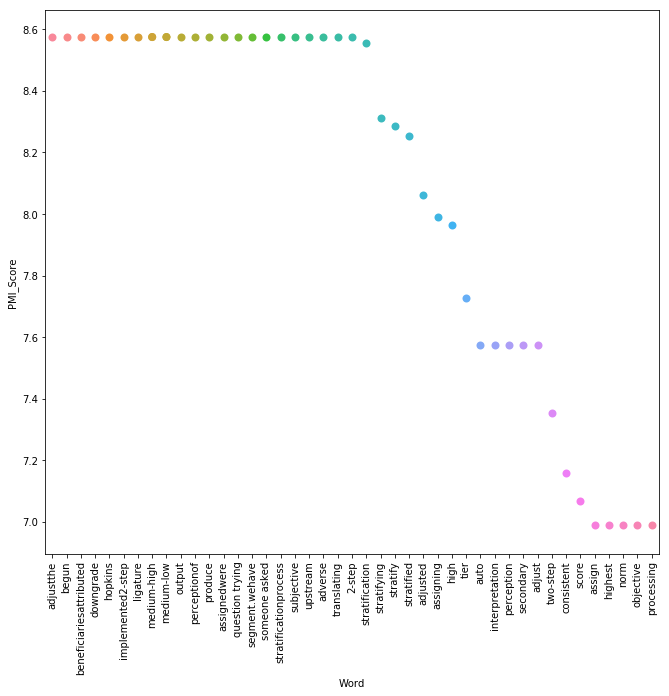

In [115]:
graphing_single_word_finder('risk',mode='single')


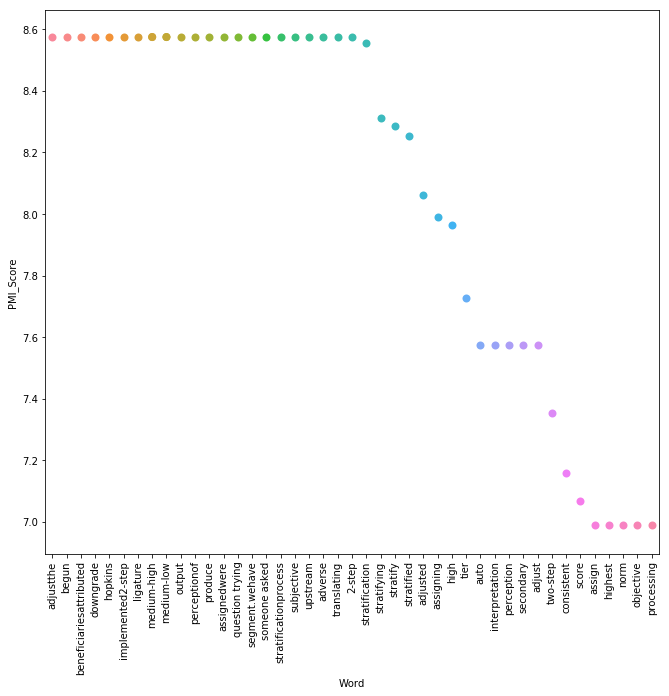

In [116]:
#Saving figures
saved_graph=graphing_single_word_finder('risk',mode='single')
type(saved_graph)
fig=saved_graph.get_figure()
fig.savefig('word_correlation_year.png')

In [117]:
graphing_data=single_word_finder('care','','single')
graphing_series=pd.Series(graphing_data)

graphing_series[1][1][1]



6.797410765058494

In [49]:
##Graphing most popular word by day

test_date=top_words['date'][0]

#sns.pointplot(x='date',y='frequency',hue='word',data=top_words)

##okay so this is super busy but we're getting there

#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))



test_float=float(test_date.month)+(float(test_date.day)/100)

test_float

##There must be a faster/better way to do this

top_words['new_date']=float

for i in xrange(0,len(top_words['date'])):
    top_words['new_date'][i]=float(top_words['date'][i].month)+(float(top_words['date'][i].day)/100)
    


C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



(2.02, 2.3)

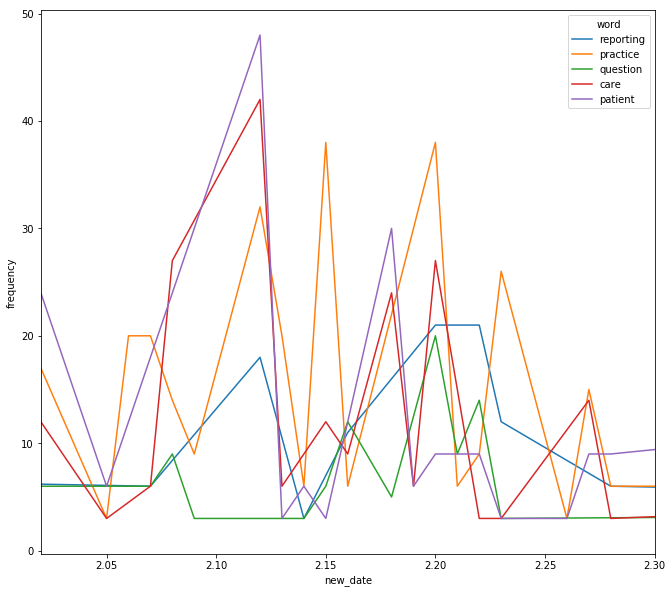

In [50]:
top_words['frequency']=top_words['frequency'].astype(float)

top_words

top_words.dtypes
ax=sns.tsplot(time='new_date',value='frequency',condition='word',unit='word',data=top_words)

#will need to figure out how to do some auto scaling on the plt xlim to get a better view than the default
plt.xlim(2.02,2.3)

## Sentiment Analysis

In [121]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\583185\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [122]:
sid=SentimentIntensityAnalyzer()
##so this will make a list with all of the sentences analyzed--- compound is the final score ranging from -1 to 1... and then you can get a breakdown of each individual score (how neg/netural/post it is)
##Vader should be the package that we use (formulated for social media results+sweet ass name) but not passing my eye test so far
##if we edit the vader_lexicon.txt file we could add words or change the weighting...
##only would need the token and a score... doesn't use the list of ratings or the standard deviation
##suggested adds-- question should be negative... figure also
##but could you do this on a script basis-- can't have everyone doing this manually
listed_sents=final_report['Body'].tolist()
all_sents=[]
for sentence in listed_sents:
    print(sentence)
    ss=sid.polarity_scores(sentence)
    all_sents.append(ss)
    for i in sorted(ss):
        print(i,ss[i])


CPC+ PRACTICE PORTAL OUTAGE ALERT: Today, Thursday, April 5th 9:00 pm ET to 10:00 pm ET.

Plan ahead! Due to maintenance, the CPC+ Practice Portal will be offline Today, Thursday, April 5th 9:00 pm ET to 10:00 pm ET.
Thank you for your patience during this brief outage.

('compound', 0.6399)
('neg', 0.029)
('neu', 0.862)
('pos', 0.11)
Our practice has not yet received an email regarding our care delivery reporting results. Am I missing something ? Has anyone else not received their performance results? Will we get one regardless?
('compound', 0.3695)
('neg', 0.065)
('neu', 0.825)
('pos', 0.11)
Hi All! Would someone kindly clarify how the performance rate for the CMS138v6 (Tobacco Use Screening and Cessation Intervention) will be calculated?  I recognize this is a multi-strata measure; however, is only one stratum to be used for our final performance.  If so, which is this stratum and what would be the equivalent NQF0028 version? Any clarification would be very helpful.
('compound', 0.7

('neg', 0.0)
('neu', 0.745)
('pos', 0.255)
What is the strategic vision, in narrative form, that you all have for your practices?
('compound', 0.25)
('neg', 0.0)
('neu', 0.875)
('pos', 0.125)
Did everyone receive the "Q1 payment update" today?  Can you share how you understand the changes?
('compound', 0.3736)
('neg', 0.0)
('neu', 0.854)
('pos', 0.146)
Check out this week?s edition of On the Plus Side for CPC+ information, resources and tools!

In this issue, find a new FAQ addressing your questions on Care Delivery and practice Audits, read about Care Delivery requirements for Q1 2018, learn about all the upcoming CPC+ events and deadlinesand much more!

('compound', 0.7896)
('neg', 0.0)
('neu', 0.873)
('pos', 0.127)
Haven't booked your accommodations for the National Meeting yet? There's still time to take advantage of special hotel rates. Check out the National Meeting website for the most up-to-date hotel information and book your room today. Space is limited!

('compound', 0.4753)

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
I signed up for the PIA that is going on in 5 minutes but cannot find the link or information on it. Does anyone have that link?
('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
 and @Deborah Weinstein

I believe you presented during the learning lesson. I was wondering about your news letter and the measure of the month. How much detail do you put in the news letter?

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
Who is using Cerner for your EMR in South Jersey?
Thanks Cathy
('compound', 0.4404)
('neg', 0.0)
('neu', 0.791)
('pos', 0.209)
DEADLINE: The 2017 CPC+ electronic Clinical Quality Measure (eCQM) submission period closes in 1 days on February 28 at 11:59 pm ET. Your practice should not wait until the end of February to submit eCQM results. Even if your practice is not eligible for the performance-based incentive payment (PBIP) due to your Medicare Shared Savings Program ACO participation, you are still 

('neu', 0.84)
('pos', 0.084)
Can anyone send me a link to a generic care plan and/or disease specific care planused by their chronic care managers?

('compound', 0.8625)
('neg', 0.0)
('neu', 0.625)
('pos', 0.375)
We are researching information on theComprehensive Medication Management (CMM). There is discussion in the 2018 Implementation Guide about training/certification of a Nurse Practitioner in the field of the CMM. (page 49) Is anyone doing this through your Nurse Practitioners?

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
How and when will we be notified about the result for the CQM's.

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)

Did you miss the final part of theCare Delivery Orientation Series: Planned Care and Population Health? Click on the link below to learn about how a fellow CPC+ practice has succeeded in implementing this important Care Delivery requirement, including best utilizing EHR data, implementing preventative care, and much more!

('co

('compound', 0.937)
('neg', 0.03)
('neu', 0.646)
('pos', 0.323)
Interested in using data to reduce emergency department visits? 
Click the link below to check out CPC+ Spotlight 8! This practice spotlight focuses onFamily Practice Associates efforts in using data to reduce emergency department visits in their medical community.

('compound', -0.4199)
('neg', 0.124)
('neu', 0.815)
('pos', 0.061)
Join us, TODAY at 4 PM- 5 PM ET, for the second webinar in the five-part series, Care Delivery Orientation Series: Care Management.Today's webinar willdescribe the primary care function of Care Management and discuss foundational concepts, including longitudinal and episodic care management and risk stratification. During the event, you will hear from a CPC+ practice that has implemented high-impact care management changes to achieve the CPC+ aims. You will also have a chance to ask questions during the live Q&A portion of the event.

('compound', 0.9652)
('neg', 0.022)
('neu', 0.736)
('pos', 0.

('compound', 0.8225)
('neg', 0.0)
('neu', 0.699)
('pos', 0.301)
Hello!
Have you registered for today's Practices in Action session, Agreeing on How to Share the Care with Specialists? Joinus from 1:30 PM to 2:00 PM Eastern!This PIA session will describe core elements of collaborative care agreements, and how your practice can use them to improve communications and coordination of care between specialists, patients, and your primary care team. Register by clicking the link below! Today?s slides are now available for download. Additional resources will be available after the session.


('compound', 0.9707)
('neg', 0.0)
('neu', 0.753)
('pos', 0.247)
I have a few questions.

1. How have practices introduced their care manager to the staff and explain their role?
2. How did you get your practice on the same page to work together?
3. How have practices delegated new duties (ex: providing patients with info on transportation, access to food, setting up HHA) to employees that are experiencing 

('compound', 0.7033)
('neg', 0.022)
('neu', 0.907)
('pos', 0.071)
Hi,

When will the details regarding the Comprehensive Medication Management for Track 2 2017 starters be available?

Thank you,

Ellen Guerin

('compound', 0.5423)
('neg', 0.0)
('neu', 0.8)
('pos', 0.2)
How can I find the feedback report for my office? I found some statewide ones in the Libraries section of this forum but I am a little lost. This is my first posting and first time using this site. Thank you for any help you can provide.

('compound', 0.6474)
('neg', 0.051)
('neu', 0.811)
('pos', 0.138)
An advanced Health IT function required for Track 2 practices by program year 3 (1/1/19) is to "Enable primary care practices to capture or electronically access an inventory of resources and supports to meet patients? identified psychosocial needs." Can we meet this requirement with links within the EHR that leadusers to an intranet pages and/or documents outside the EHR? Maintaining the inventory of resource files outsi

('compound', 0.7096)
('neg', 0.045)
('neu', 0.813)
('pos', 0.143)
Did you miss the2018 eCQM and Health IT Reviewon October 25thor need a refresher? Check out the event recording to learn how to pick your eCQM measures for program year 2, find out the protocol for switching health IT Vendors and much more!

('compound', -0.2244)
('neg', 0.044)
('neu', 0.956)
('pos', 0.0)
I was looking through the participation agreement recently after talking with a track two practice. I was told by this practice that they mandatory audits in December for cpc+. Is this true for all cpc+ track 1 practices too or just track 2?

('compound', 0.775)
('neg', 0.0)
('neu', 0.823)
('pos', 0.177)
Are you a Track 2 practice that uses Allscripts as your health IT vendor? Vendors are hosting capability and collaboration affinity groups. Capability Affinity Group Meetings provide an opportunity for Track 2 practices to interact directly with this vendor on topics related to Track 2 health IT requirements. You can jo

('pos', 0.0)
We're focusing on Social Determinants of Health and planning out the workflow for our practice. Before I build anything in our system I want to make sure we have all the nitty gritty details about the requirements: what specific questions need to be asked, if/how it will be tracked, if there's a benchmark percentage of patients to be asked, etc.No detail is too small.
I'm hoping someone has information handy about this - or knows what page to find it on a specific document -since I unfortunately don't have time to wade through everything. If it's something which will be tracked for credit later, there's a good chance I'll be working with our EMR to build it together, and we'll need all the info we can get.
Thank you in advance for your help!

('compound', 0.9324)
('neg', 0.017)
('neu', 0.844)
('pos', 0.139)
Does the the Amended and Restated Participation Agreement need to be submitted for each site, or one per TIN? I have 7 sites, but only received 1 e-mail.
Thanks.

('com

('compound', 0.9504)
('neg', 0.0)
('neu', 0.69)
('pos', 0.31)
We are a Track 2 CPC+ practice and have several Collaborative agreements in place with BH practitioners. We are looking to take advantage of BH consulting services offered to us, but wondered what are the requirements for CPC+? Are there a number of hours expected? We will be paying by the hour and just wantto budget wisely.
Thank you in advance.

('compound', 0.8693)
('neg', 0.0)
('neu', 0.818)
('pos', 0.182)
Payer requirements and CPC+ requirements seem to be contradictory when it comes to what a PCP is considered for reporting. Are other practices having this issue and if so how are you handling it?

('compound', -0.34)
('neg', 0.07)
('neu', 0.93)
('pos', 0.0)
PLAN AHEAD ?OUTAGEALERT:Due to maintenance, the CPC+ Practice Portal will be unavailable during this upcoming time period:
- Saturday, September 30, 12:00 am ET to Sunday, October1, 12:00 pm ET.
Thank you for your patience during this briefoutage.

('compound', 0.36

('pos', 0.143)
Is anyone having an issue trying to figure out if the EMR can pull the eCQM reports or if they should come out of a registry? Or is it a combination?

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
. We understand that this change will begin in April 2018. The CMS information states that
Medicare plan exceptions:
- Appeals - You can use either the HICN or the MBI for claims appeals and related forms.
- Adjustments - You can use the HICN indefinitely for some systems (Drug Data Processing, Risk Adjustment Processing, and Encounter Data) and for all records, not just adjustments.- Reports - We?ll use the HICN on these reports until further notice:- Incomingtous (quality reporting, Disproportionate Share Hospital data requests, etc.)
- Outgoingfromus (Provider Statistical & Reimbursement Report, Accountable Care Organization reports, etc.


What does this mean for our CPC+ reports - Attribution files, Feedback reports, etc?

('compound', 0.5661)
('neg', 0.019)
('n

('neu', 0.743)
('pos', 0.183)
FEEDBACK REPORT UPDATE: The second practice feedback reports will be available by this Friday, August 4, 2017. This report contains Quarter 1 claims, utilization, practice-specific specialty, and care delivery data for your practice's Medicare fee-for-service beneficiaries, and can be accessed from the CPC+ Practice Portal in the "Reports" tab.

If you have any additional questions, please post to the "CPC+ All" group on CPC+ Connect or reach out to your regional practice facilitator.
Please note that the regional feedback reports will be available on CPC+ Connect next week on Friday, August 11, 2017.

('compound', 0.8658)
('neg', 0.0)
('neu', 0.881)
('pos', 0.119)
Interested in insights on how to make patient engagement an everyday practice for your care team? Click below to check out NEJM Insight Council?s recent report on hardwiring patient engagement into your team?s care delivery!

('compound', 0.9426)
('neg', 0.0)
('neu', 0.653)
('pos', 0.347)
Are an

('neu', 0.842)
('pos', 0.158)
Question on TOC and ER follow up calls
If a patient is attributed to our office from the local hospital but has not been seen in our office for a number of years and our contact information is not valid, to what extent do we need to go in order to try to contact the patient?

('compound', 0.1154)
('neg', 0.0)
('neu', 0.973)
('pos', 0.027)
Check out the newest On-Demand webinar from CPC+ (Access & Continuity: 24/7 Access) which focuses on how to increase access for your patients!

('compound', 0.3802)
('neg', 0.0)
('neu', 0.89)
('pos', 0.11)
reporting question:
Sec 4.2 We engage patients/caregivers as equal partners in...improvement projects.
What types of improvement projects does this question refer to? clinical improvement projects such as improving your BMI or practice improvements like improving access to care?

('compound', 0.9655)
('neg', 0.0)
('neu', 0.573)
('pos', 0.427)
Reporting question:

Sec2.1 What system do you use for risk stratification?

W

('neu', 0.879)
('pos', 0.095)
Mark your calendars, CPC+!
Our weekly newsletter,On the Plus Side, is moving from Fridays toTuesdays starting June 6, 2017. The new delivery day comes with a fresh look and some new features like?CPC+ Spotlights?! Don?t miss out on essential CPC+ information, tools and announcements each week. ContactCPC+ Supportto subscribe today!

('compound', 0.4795)
('neg', 0.031)
('neu', 0.898)
('pos', 0.071)
CPC+ PORTAL OUTAGE: Due to maintenance, the CPC+ Practice Portal will be unavailable from Friday, May 26 at 9:00 am ET to Monday, May 29 at 1:00 am ET. Thank you for your patience during this brief outage.

('compound', 0.3612)
('neg', 0.0)
('neu', 0.937)
('pos', 0.063)
Simple action plan shared with all patients at our office.

('compound', 0.34)
('neg', 0.0)
('neu', 0.789)
('pos', 0.211)
Will CMS increase the risk adjusted CMF and the PBIP PBPM payment amounts in year 2 or beyond?

('compound', 0.0516)
('neg', 0.108)
('neu', 0.773)
('pos', 0.119)
Is the region 

('neu', 0.621)
('pos', 0.379)
Still have practice team members need access to CPC+ Connect? If you still have members that have not successfully logged onto CPC+ Connect, please look for an email invitation from the CMMI Help Desk CMMIConnectHelpDesk@cms.hhs.gov in the near future to guide your CPC+ Connect activation process. Alternatively, you may click below to self-register.

('compound', 0.3339)
('neg', 0.046)
('neu', 0.868)
('pos', 0.087)
Can anyone please share an example of there documentation for care management fee spending 

('compound', 0.7717)
('neg', 0.0)
('neu', 0.588)
('pos', 0.412)
We had 504 of you join us for theUnderstanding CPC+ and the Quality Payment Program eventon April 20th. If you did not get a chance to download a copy of the slides during the event, they are now available. A recording of this session will be available on CPC+ Connect by the end of next week.

('compound', 0.1179)
('neg', 0.032)
('neu', 0.928)
('pos', 0.04)
What comprises the "reference popu

('neg', 0.0)
('neu', 0.843)
('pos', 0.157)
On the Oregon call last week, one group mentioned they wanted to see if there was any way to monitor/prevent Provider Burnout. Our Medical Director and myself have just started this reporting journey, so I figured I'd share what we're looking at. Any Provider that charts (tasking, signing off notes, documenting in the encounter notes) between 6PM and 7AM are counted. We do exclude those providers that work our Evening Clinic for the day they are in that clinic as well as those providers who are On Call (we exclude them from that night and the next morning).
Since there aren't really any benchmarks/standards out there, has any other group tried reporting on this?

('compound', 0.1935)
('neg', 0.032)
('neu', 0.929)
('pos', 0.039)
Did you miss the Care Delivery and eCQM Office Hour on Wednesday, March 22, 2017, or would you like to listen to it again? If so, check out the event recording, which is now available by clicking the link below.

('comp


('compound', 0.0772)
('neg', 0.145)
('neu', 0.687)
('pos', 0.168)
Does anyone have a care compact/ collaborate care agreement that they have used to satisfy 3.2 CARE COMPACTS/AGREEMENTS WITH HIGH VOLUME SPECIALISTS?  Thanks

('compound', 0.9609)
('neg', 0.0)
('neu', 0.452)
('pos', 0.548)
I was reading the newsletter this morning and it stating that this week the regional learning launch is this week and to go to the calendar section in connect. I do not see anything on the calendar. There is also two groups for my region so I am unsure which one I am supposed to be in. If anyone has any info I would greatly appreciate it.

('compound', 0.1815)
('neg', 0.035)
('neu', 0.919)
('pos', 0.046)
Our practice is trying to get a head start on the quarterly care delivery reporting and I have some questions. For hospital and emergency room follow ups our office is concerned that we currently have no way of tracking all of these ED and hospital patients because we do not always get reports from th

In [123]:
#assign a netural/negative/positive to the final report
#THIS IS COMPLETLEY ARBITRARY, I was going to use the max score for each dictionary entry, but most of them were netural.. using compound in stead

final_report['sentiment']=str
final_report['sentiment_score']=int

for i in range(0,len(all_sents)):
    final_report['sentiment_score'].iloc[i]=all_sents[i]['compound']
    if(all_sents[i]['compound']<-.3):
        final_report['sentiment'].iloc[i]= "negative"
    elif(all_sents[i]['compound']>.3):
        final_report['sentiment'].iloc[i]="positive"
    else:
        final_report['sentiment'].iloc[i]="neutral"
        

In [124]:
sentiment_list=['Body','sentiment','sentiment_score']

sentiment_report=final_report[sentiment_list]



print("percentage of netural sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='neutral']))/float(len(sentiment_report)),"percent of positive sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='positive']))/float(len(sentiment_report)),"percent of negative sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='negative']))/float(len(sentiment_report)))

('percentage of netural sentences=', 0.27425373134328357, 'percent of positive sentences=', 0.6529850746268657, 'percent of negative sentences=', 0.07276119402985075)


In [125]:
##Pie Graph


init_notebook_mode(connected=True)

labels=['Neutral','Positive','Negative']
values=[(len(sentiment_report[sentiment_report['sentiment']=='neutral'])),(len(sentiment_report[sentiment_report['sentiment']=='positive'])),(len(sentiment_report[sentiment_report['sentiment']=='negative']))]


sentiment_pie=go.Pie(labels=labels,values=values)

offline.iplot([sentiment_pie],filename='sentiment pie')

## Topic Modeling

In [35]:
final_report.shape

(199, 12)

In [36]:
token_list = final_report['Body'].map(tokenizer)

# get dictionary for the corpus
corp_dict = corpora.Dictionary(token_list)

# filter down dictionary
corp_dict.filter_extremes(no_below=4, no_above=0.5, keep_n=100000, keep_tokens=None)
corp_dict.compactify()  # remove gaps in id sequence after words that were removed
print(corp_dict)

Dictionary(329 unique tokens: [u'caregiver', u'code', u'help', u'office', u'action group']...)


In [37]:
corpus_master = [corp_dict.doc2bow(token) for token in token_list]

In [38]:
k = 125  # number of topics
min_prob = 0.2  # controls filtering the topics returned for a document
lda = models.LdaModel(corpus_master, id2word=corp_dict, num_topics=k, passes=5, minimum_probability=min_prob)

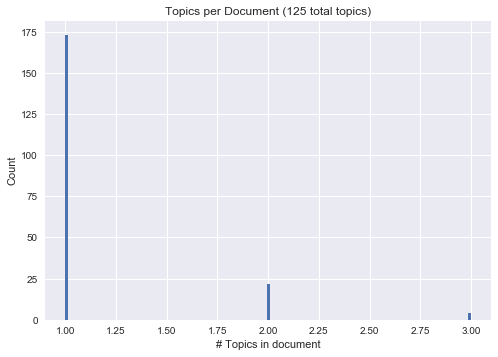

In [39]:
def plot_topics_per_doc(model, corpus, k):
    plt.style.use('seaborn')
    n_topics = []
    for doc in corpus_master:
        n_topics.append(len(lda.get_document_topics(doc)))
    n_topics
    
    plt.title('Topics per Document (' + str(k) + ' total topics)')
    plt.xlabel('# Topics in document')
    plt.ylabel('Count')
    plt.hist(n_topics, bins=k)
    plt.show()
    
plot_topics_per_doc(lda, corpus_master, k)

In [40]:
import operator

# returns DataFrame with topics and # of documents they appear in, sorted most to fewest
def get_topic_freq(lda, corpus):
    topic_counts = dict.fromkeys(range(k), 0)
    for doc in corpus:
        for topic in lda.get_document_topics(doc):
            topic_counts[topic[0]] += 1
    return pd.DataFrame(sorted(topic_counts.items(), key=operator.itemgetter(1), reverse=True), columns=['Topic', 'n_docs'])

# plot a sorted, horizontal bar chart of top topics
def plot_top_topics(lda, topic_freq, n):
    plt.style.use('seaborn')
    top = topic_freq[:n]
    if (n>25):
        plt.figure(figsize=(20, 22))
        plt.rcParams.update({'font.size': 40})
        plt.yticks(range(n), [[x[0] for x in lda.show_topic(t)] for t in top['Topic']], fontsize = 20)
    else:
        plt.yticks(range(n), [[x[0] for x in lda.show_topic(t)] for t in top['Topic']])
    plt.barh(range(n), top['n_docs'])
    
    plt.gca().invert_yaxis()
    plt.title('Top ' + str(n) +' topics')
    plt.xlabel('# documents containing topic')
    
    plt.show()

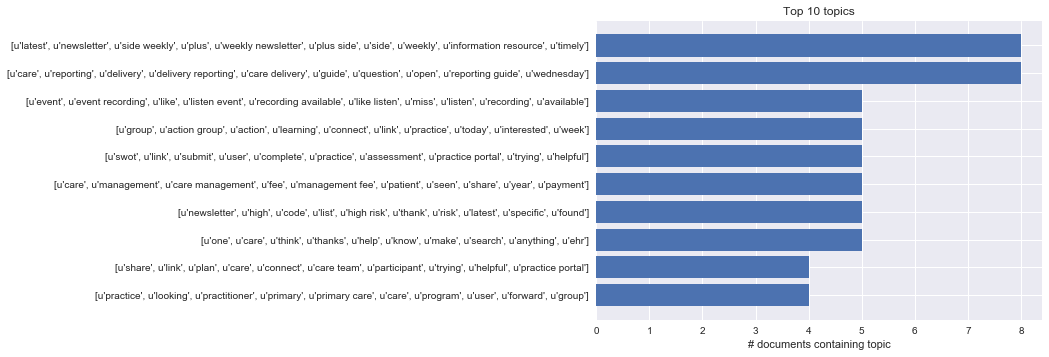

In [41]:
topic_freq = get_topic_freq(lda, corpus_master)
plot_top_topics(lda, topic_freq, 10)

In [42]:
def assign_topic_to_doc(lda, corpus, report):
    i= 0
    report['Topic'] = "NA"

    for doc in corpus:
        doc_topic = lda.get_document_topics(doc)[0][0]
        topic_list = []
        for x in lda.show_topic(doc_topic):
            topic_list.append(x[0])
        report['Topic'].iloc[i] = topic_list
        i += 1
    return report


In [43]:
topics_report = assign_topic_to_doc(lda, corpus_master, final_report)

In [44]:
topics_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type,tokens,sentiment,sentiment_score,Topic
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post,"[portal, access, portal access]",neutral,0,"[access, practice, portal, medicare, able, pra..."
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post,"[trying, figure, document/track, use, cmf, pay...",positive,0.5204,"[required, use, additional, wondering, cmf, an..."
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post,"[appreciate, participation, care, management, ...",positive,0.7096,"[webinar, recording, next week, slide, downloa..."
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post,"[group, created, within, connect, saw, post, t...",positive,0.75,"[group, start, created, post, connect, within,..."
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post,"[attention, practice, payer, region, partnerin...",positive,0.6939,"[payer, cm, practice, survey, u, like, give, r..."


In [45]:
topics_report.to_excel('output.xlsx')

ImportError: No module named openpyxl

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook() 
pyLDAvis.gensim.prepare(lda, corpus_master, corp_dict, mds='mmds')
#pyLDAvis.display(vis_data)

In [ ]:
lda.print_topic(1,topn=10)